In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as skpp
# XGBoost
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
import xgboost as xgb # must be in AMN_windows env
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List


# PATH = "biolog_metabolic_genes_single_only.csv"
PATH = "biolog_metabolic_genes.csv"
# PATH = "biolog_metabolic_genes_low_std.csv"

all_data = pd.read_csv(PATH, index_col=0)
# all_data_norm = (all_data - all_data.mean()) - all_data.std()
all_data

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
0,b3091 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,0.7800,Blattner Laboratory
1,b3093 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.4300,Blattner Laboratory
2,b3132 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.0400,Blattner Laboratory
3,b3137 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.0900,Blattner Laboratory
4,b3161 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,0.9100,Blattner Laboratory
...,...,...,...,...,...
17875,b4138 mutant Biolog assay,OD600 growth,L-Serine,1.8300,Blattner Laboratory
17876,b4138 mutant Biolog assay,OD600 growth,L-Methionine,1.1225,Blattner Laboratory
17877,b4138 mutant Biolog assay,OD600 growth,Cytosine,1.8400,Blattner Laboratory
17878,b4138 mutant Biolog assay,OD600 growth,L-Tryptophan,0.9300,Blattner Laboratory


<AxesSubplot:xlabel='Data Value', ylabel='Count'>

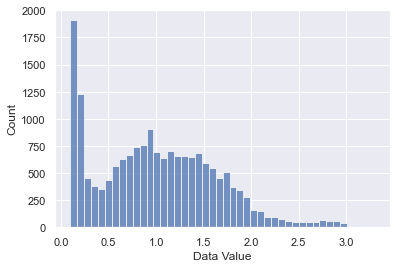

In [2]:
plt.close('all')
sns.set_theme()
sns.histplot(all_data["Data Value"])

In [3]:
print("Unique mutants number: ", len(set(all_data['Experiment Description'])))
print("Unique substrates number: ", len(set(all_data['Well Substrate'])))

Unique mutants number:  120
Unique substrates number:  149


In [4]:
target_gene_encoder = skpp.OneHotEncoder()
which_CS_encoder = skpp.OneHotEncoder()

raw_target_gene = all_data["Experiment Description"].values.reshape(-1, 1)
raw_which_medium = all_data["Well Substrate"].values.reshape(-1, 1)

target_gene_encoder.fit(raw_target_gene)
which_CS_encoder.fit(raw_which_medium)

X_left = target_gene_encoder.transform(raw_target_gene).toarray()
X_right = which_CS_encoder.transform(raw_which_medium).toarray()

X = np.hstack((X_left, X_right))

# raw_X = all_data.iloc[:,:3].values
# enc.fit(raw_X)
# X = enc.transform(raw_X).toarray()

Y = all_data["Data Value"].values.reshape(-1, 1)
print(X.shape, Y.shape)

(17880, 269) (17880, 1)


In [5]:
LOO_split = int(Y.shape[0])

xgb_preds = []

for i in range(1):

    # XGBoost = xgb.XGBRegressor(n_estimators=600, max_depth=2, learning_rate=0.01, objective='reg:squarederror', random_state=i)

    multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror'))
    
    xgb_pred = cvp(multioutputregressor, X, Y, cv=KFold(n_splits=10, shuffle=True, random_state=i), n_jobs=10)
    
    xgb_preds.append(xgb_pred)

In [6]:
xgb_preds

[array([[0.9823063],
        [1.0865618],
        [1.0384889],
        ...,
        [1.2984571],
        [1.1753603],
        [1.182778 ]], dtype=float32)]

In [7]:
mean_xgb_pred = np.array(xgb_preds).mean(axis=0)
std_xgb = np.array(xgb_preds).std(axis=0)

print("Mean squared error between mean prediction and true fluxes", np.mean((mean_xgb_pred - Y)**2, axis=0))
# MSE between mean prediction (over 5 times 10-fold test sets) and true

print("Q²: ", r2_score(Y, mean_xgb_pred))

Mean squared error between mean prediction and true fluxes [0.10958075]
Q²:  0.7287191138598418


all data: 

Mean squared error between mean prediction and true fluxes [0.10932903]
Q²:  0.729

only single:

Mean squared error between mean prediction and true fluxes [0.12198846]
Q²:  0.730201885417885

low_std:

Mean squared error between mean prediction and true fluxes [0.11753889]
Q²:  0.739352712972696

<AxesSubplot:ylabel='Count'>

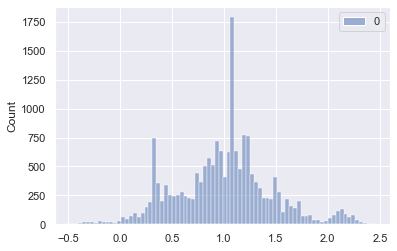

In [8]:
sns.histplot(mean_xgb_pred)